<a class="anchor" id="1"></a>
## 1. Import libraries 

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits import mplot3d
from scipy import stats
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# models
from sklearn.linear_model import LinearRegression,LogisticRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr

import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

<a class="anchor" id="2"></a>
## 2. Download datasets

In [2]:
features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']

In [3]:
train0 = pd.read_csv('data.csv')
train0 = train0[features]
train0.head(5)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000.0,3.0,1.50,1340,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2384000.0,5.0,2.50,3650,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,342000.0,3.0,2.00,1930,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,420000.0,3.0,2.25,2000,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,550000.0,4.0,2.50,1940,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train0.columns.values.tolist()
for col in features:
    if train0[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        le.fit(list(train0[col].astype(str).values))
        train0[col] = le.transform(list(train0[col].astype(str).values))

In [5]:
train0['price'] = (train0['price']).astype(int)
train0['floors'] = (train0['floors']).astype(int)
train0['bedrooms'] = (train0['bedrooms']).astype(int)

<a class="anchor" id="3"></a>
## 3. EDA

In [6]:
valid_part = 0.3
pd.set_option('max_columns',100)

In [7]:
train0 = train0.dropna()
train0.head(5)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000,3,1.50,1340,1,0,0,3,1340,0,1955,2005,1522,36,62,0
1,2384000,5,2.50,3650,2,0,4,5,3370,280,1921,0,3899,35,58,0
2,342000,3,2.00,1930,1,0,0,4,1930,0,1966,0,2291,18,26,0
3,420000,3,2.25,2000,1,0,0,4,1000,1000,1963,0,4263,3,7,0
4,550000,4,2.50,1940,1,0,0,4,1140,800,1976,1992,4352,31,31,0


In [8]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4600 entries, 0 to 4599
Data columns (total 16 columns):
price            4600 non-null int64
bedrooms         4600 non-null int64
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
floors           4600 non-null int64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     4600 non-null int64
street           4600 non-null int64
city             4600 non-null int64
statezip         4600 non-null int64
country          4600 non-null int64
dtypes: float64(1), int64(15)
memory usage: 610.9 KB


In [9]:
train0.corr()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
price,1.000000,0.200336,0.327110,0.430410,0.137125,0.135648,0.228504,0.034915,0.367570,0.210427,0.021857,-0.028774,0.029366,0.018625,-0.043385,NaN
bedrooms,0.200336,1.000000,0.545920,0.594884,0.157433,-0.003483,0.111028,0.025080,0.484705,0.334165,0.142461,-0.061082,-0.035507,-0.130447,-0.152773,NaN
bathrooms,0.327110,0.545920,1.000000,0.761154,0.498436,0.076232,0.211960,-0.119994,0.689918,0.298020,0.463498,-0.215886,0.007175,-0.097026,-0.194497,NaN
sqft_living,0.430410,0.594884,0.761154,1.000000,0.340993,0.117616,0.311009,-0.062826,0.876443,0.447206,0.287775,-0.122817,0.006411,-0.109686,-0.198918,NaN
floors,0.137125,0.157433,0.498436,0.340993,1.000000,0.017955,0.021116,-0.306464,0.517319,-0.253308,0.562218,-0.247150,0.037869,0.035746,-0.087240,NaN
waterfront,0.135648,-0.003483,0.076232,0.117616,0.017955,1.000000,0.360935,0.000352,0.078911,0.097501,-0.023563,0.008625,0.035448,0.001450,0.007938,NaN
view,0.228504,0.111028,0.211960,0.311009,0.021116,0.360935,1.000000,0.063077,0.174327,0.321602,-0.064465,0.022967,0.065077,0.001340,0.079340,NaN
condition,0.034915,0.025080,-0.119994,-0.062826,-0.306464,0.000352,0.063077,1.000000,-0.178196,0.200632,-0.399698,-0.186818,-0.005480,-0.010592,0.027666,NaN
sqft_above,0.367570,0.484705,0.689918,0.876443,0.517319,0.078911,0.174327,-0.178196,1.000000,-0.038723,0.408535,-0.160426,-0.013709,-0.121701,-0.247666,NaN
sqft_basement,0.210427,0.334165,0.298020,0.447206,-0.253308,0.097501,0.321602,0.200632,-0.038723,1.000000,-0.161675,0.043125,0.038769,-0.001559,0.047251,NaN


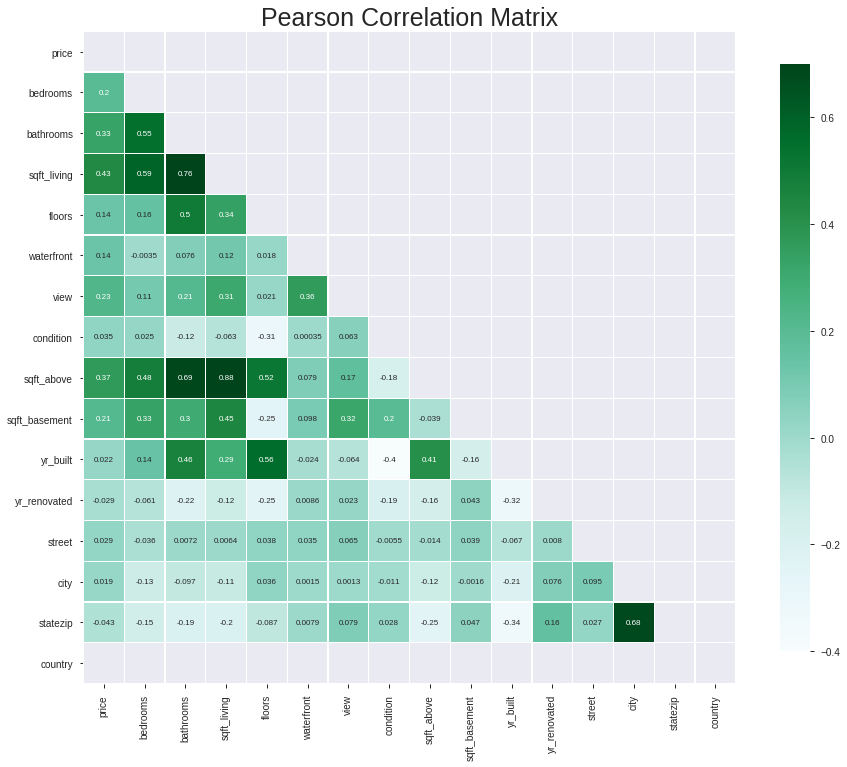

In [10]:
# Thanks to: https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices
mask = np.zeros_like(train0[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(train0[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

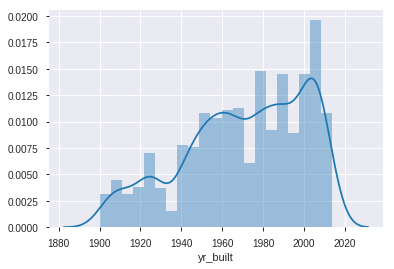

In [11]:
sns.distplot(train0['yr_built'])

In [12]:
train0.describe(percentiles=[.01, .02, .03, .05, .1, .5, .9, .92, .93, .99])

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.0
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.459130,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261,2265.385870,25.674348,38.743696,0.0
std,5.638347e+05,0.908848,0.783781,963.206916,0.552194,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536,1307.591795,11.982721,20.919517,0.0
min,0.000000e+00,0.000000,0.000000,370.000000,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.0
1%,0.000000e+00,2.000000,1.000000,720.000000,1.000000,0.000000,0.000000,3.000000,709.900000,0.000000,1903.000000,0.000000,45.990000,1.000000,0.000000,0.0
2%,1.424860e+05,2.000000,1.000000,800.000000,1.000000,0.000000,0.000000,3.000000,760.000000,0.000000,1906.000000,0.000000,90.980000,1.000000,1.000000,0.0
3%,1.699550e+05,2.000000,1.000000,860.000000,1.000000,0.000000,0.000000,3.000000,800.000000,0.000000,1909.000000,0.000000,136.970000,1.000000,2.000000,0.0
5%,2.000000e+05,2.000000,1.000000,950.000000,1.000000,0.000000,0.000000,3.000000,860.000000,0.000000,1913.000000,0.000000,227.000000,3.000000,4.000000,0.0
10%,2.399500e+05,2.000000,1.000000,1110.000000,1.000000,0.000000,0.000000,3.000000,970.000000,0.000000,1925.000000,0.000000,451.900000,3.000000,8.000000,0.0
50%,4.609430e+05,3.000000,2.250000,1980.000000,1.000000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,2263.500000,32.000000,41.000000,0.0


In [13]:
train0 = train0[(
                (train0['price'] <= 1000000) & 
                (train0['price'] > 150000) & 
                (train0['bathrooms'] <= 6) & 
                (train0['condition'] > 2) & 
                (train0['sqft_living'] > 800) & 
                (train0['bedrooms'] >= 1) & 
                (train0['bedrooms'] <= 4.5) 
                )]

In [14]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3720 entries, 0 to 4599
Data columns (total 16 columns):
price            3720 non-null int64
bedrooms         3720 non-null int64
bathrooms        3720 non-null float64
sqft_living      3720 non-null int64
floors           3720 non-null int64
waterfront       3720 non-null int64
view             3720 non-null int64
condition        3720 non-null int64
sqft_above       3720 non-null int64
sqft_basement    3720 non-null int64
yr_built         3720 non-null int64
yr_renovated     3720 non-null int64
street           3720 non-null int64
city             3720 non-null int64
statezip         3720 non-null int64
country          3720 non-null int64
dtypes: float64(1), int64(15)
memory usage: 494.1 KB


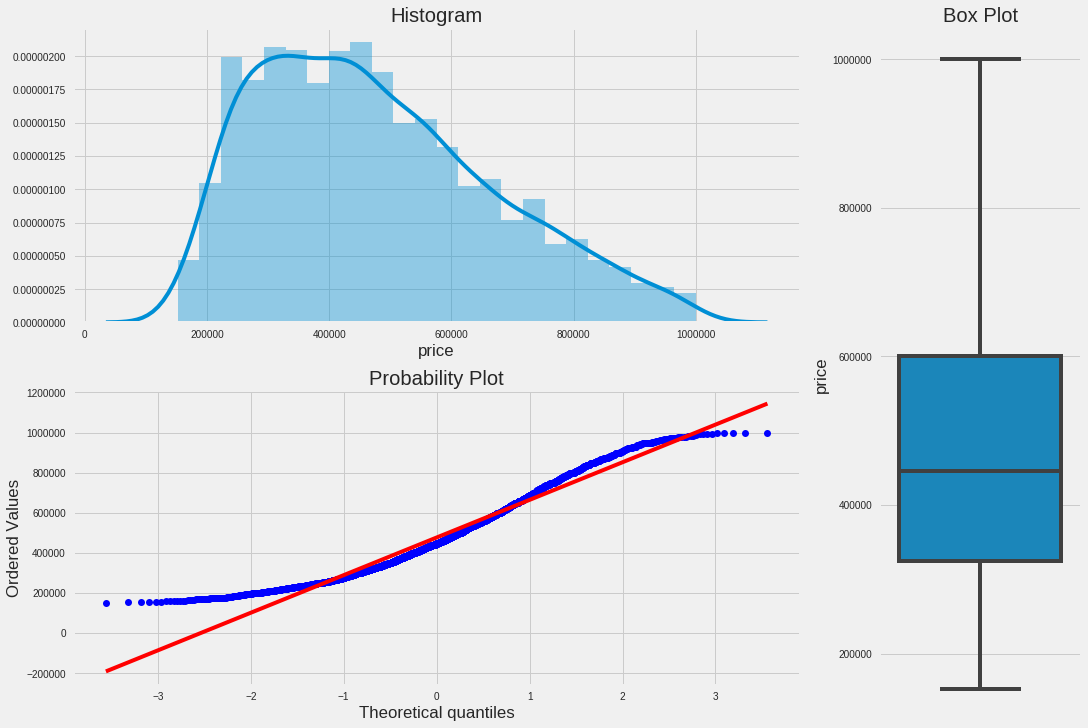

In [16]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    
    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(train0, 'price')

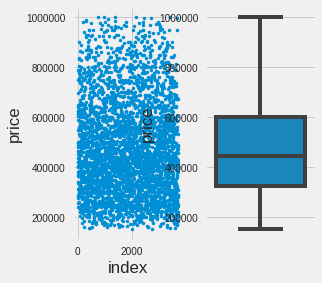

In [17]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
y = np.array(train0.price)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('price');plt.xlabel('index');
plt.subplot(132)
sns.boxplot(y=train0.price)

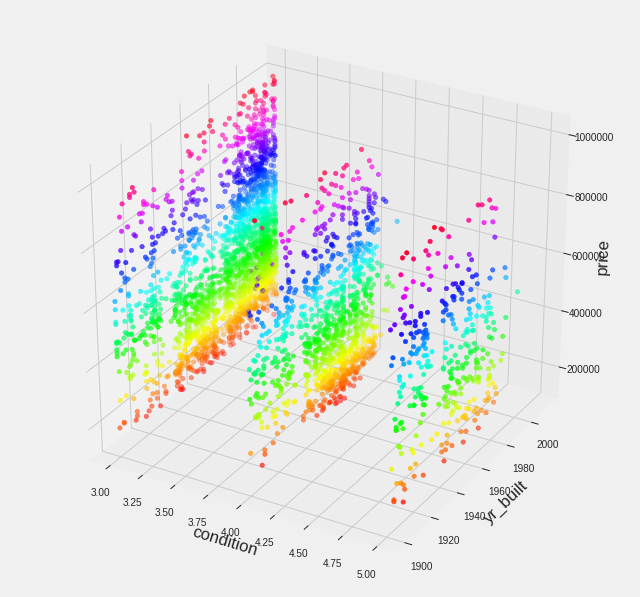

In [18]:
#Thanks to https://towardsdatascience.com/an-easy-introduction-to-3d-plotting-with-matplotlib-801561999725
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

z_points = train0['price']
x_points = train0['condition']
y_points = train0['yr_built']
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

ax.set_xlabel('condition')
ax.set_ylabel('yr_built')
ax.set_zlabel('price')

plt.show()

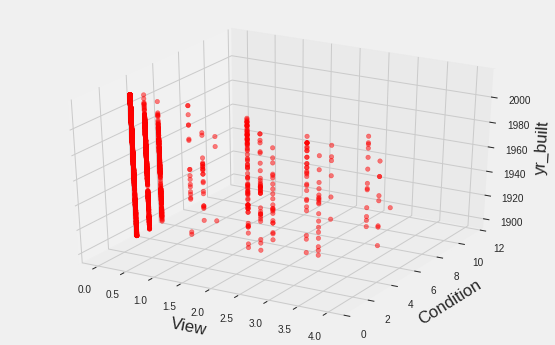

In [19]:
# Thanks to: https://www.kaggle.com/shanroy1999/house-price-prediction-using-linear-regression
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,2, projection="3d")
ax.scatter(train0['view'],train0['condition'],train0['yr_built'],c="red",alpha=.5)
ax.set(xlabel='\nView',ylabel='\nCondition',zlabel='\nyr_built')
ax.set(ylim=[0,12])
plt.show()

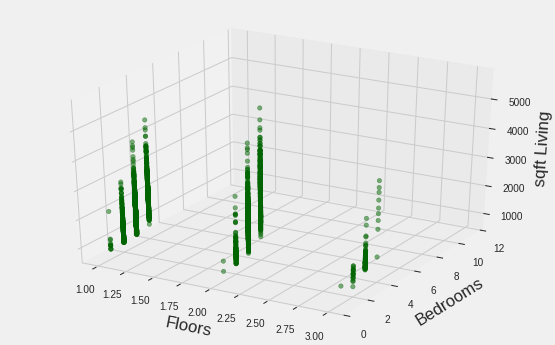

In [20]:
# Thanks to: https://www.kaggle.com/shanroy1999/house-price-prediction-using-linear-regression
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,2, projection="3d")
ax.scatter(train0['floors'],train0['bedrooms'],train0['sqft_living'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nsqft Living')
ax.set(ylim=[0,12])
plt.show()

In [21]:
# Thanks to: https://www.kaggle.com/shanroy1999/house-price-prediction-using-linear-regression
grpby_bedrooms_df = train0[["price", "bedrooms"]].groupby(by = "bedrooms", as_index = False)
grpby_bedrooms_df = grpby_bedrooms_df.mean().astype(int)
grpby_bedrooms_df.head()

,bedrooms,price
0,1,344921
1,2,409449
2,3,444431
3,4,547698


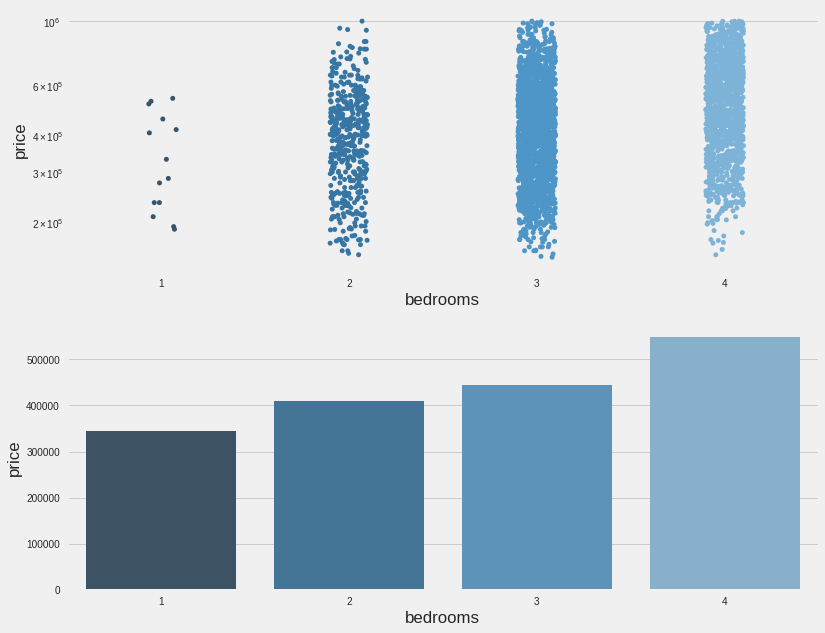

In [22]:
# Thanks to: https://www.kaggle.com/shanroy1999/house-price-prediction-using-linear-regression
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.set(yscale = "log")
sns.stripplot(x = "bedrooms", y = "price", data = train0, ax = ax1, jitter=True, palette="Blues_d")
sns.barplot(x = "bedrooms", y = "price", data = grpby_bedrooms_df, ax = ax2, palette="Blues_d")
plt.show()

<a class="anchor" id="4"></a>
## 4. FE: building the feature importance diagrams

<a class="anchor" id="4.1"></a>
### 4.1 LGBM 

In [23]:
# Clone data for FE 
train_fe = copy.deepcopy(train0)
target_fe = train_fe['price']
del train_fe['price']

In [24]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
X = train_fe
z = target_fe

In [25]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [26]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgb.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=10, valid_sets=valid_set)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 157420
[20]	valid_0's rmse: 134460
[30]	valid_0's rmse: 120266
[40]	valid_0's rmse: 111194
[50]	valid_0's rmse: 105529
[60]	valid_0's rmse: 100632
[70]	valid_0's rmse: 97486.5
[80]	valid_0's rmse: 96091.6
[90]	valid_0's rmse: 94359.5
[100]	valid_0's rmse: 93567.5
[110]	valid_0's rmse: 92618.9
[120]	valid_0's rmse: 92104.3
[130]	valid_0's rmse: 91690.4
[140]	valid_0's rmse: 91402.4
[150]	valid_0's rmse: 91103.1
[160]	valid_0's rmse: 90861
[170]	valid_0's rmse: 90830.4
[180]	valid_0's rmse: 90572.5
[190]	valid_0's rmse: 90448.3
[200]	valid_0's rmse: 90350.8
[210]	valid_0's rmse: 90315.5
[220]	valid_0's rmse: 90228.7
[230]	valid_0's rmse: 90110.5
[240]	valid_0's rmse: 90036
[250]	valid_0's rmse: 89949.9
[260]	valid_0's rmse: 89924.1
[270]	valid_0's rmse: 89829.9
[280]	valid_0's rmse: 89765.3
[290]	valid_0's rmse: 89745.3
[300]	valid_0's rmse: 89849.2
[310]	valid_0's rmse: 89852.3
[320]	valid_0's rmse: 89966.

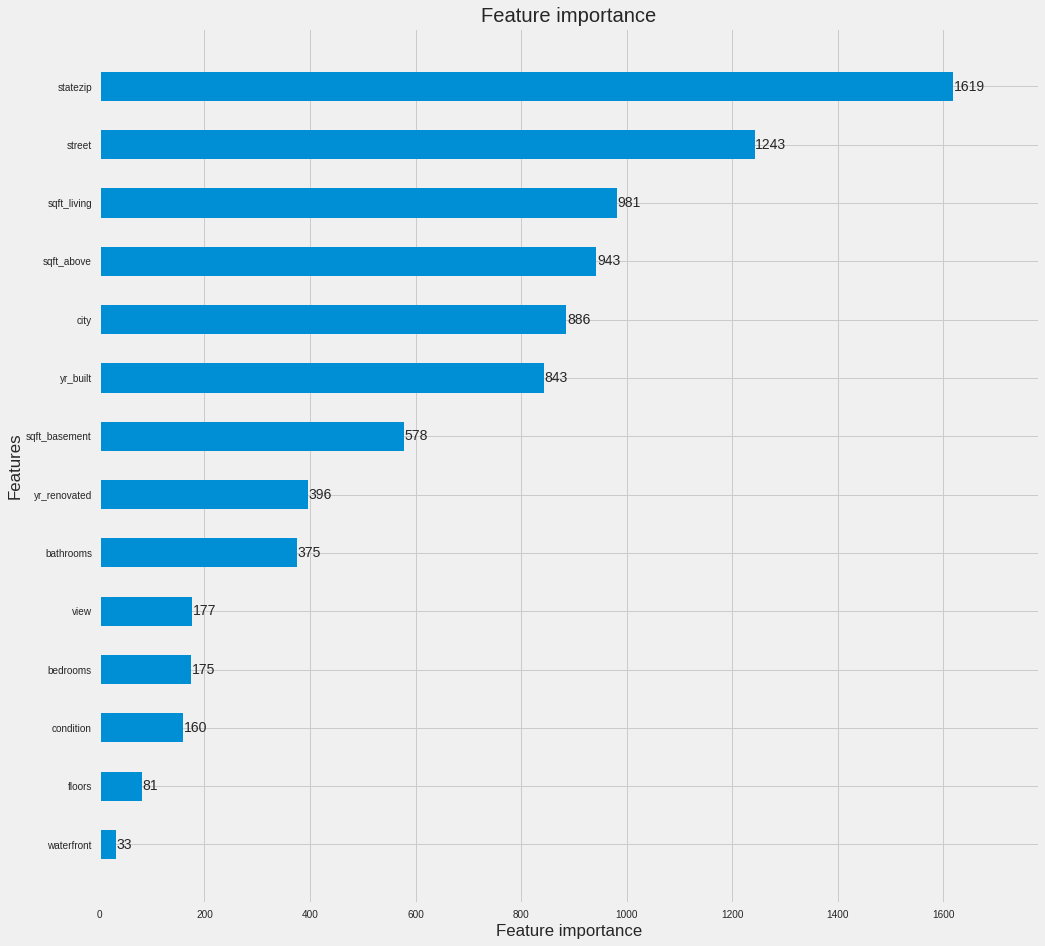

In [27]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

In [28]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
feature_score = pd.DataFrame(train_fe.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

<a class="anchor" id="4.2"></a>
### 4.2 XGB

In [29]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
#%% split training set to validation set 
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [30]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[0]	train-rmse:371082	valid-rmse:375109
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[10]	train-rmse:79778.3	valid-rmse:104633
[20]	train-rmse:63974.7	valid-rmse:100052
[30]	train-rmse:56234.1	valid-rmse:100485
[40]	train-rmse:51167.4	valid-rmse:100947
[50]	train-rmse:46317.2	valid-rmse:101939
Stopping. Best iteration:
[21]	train-rmse:62905.8	valid-rmse:99656.4

score = 99656.41406, n_boost_round =21.


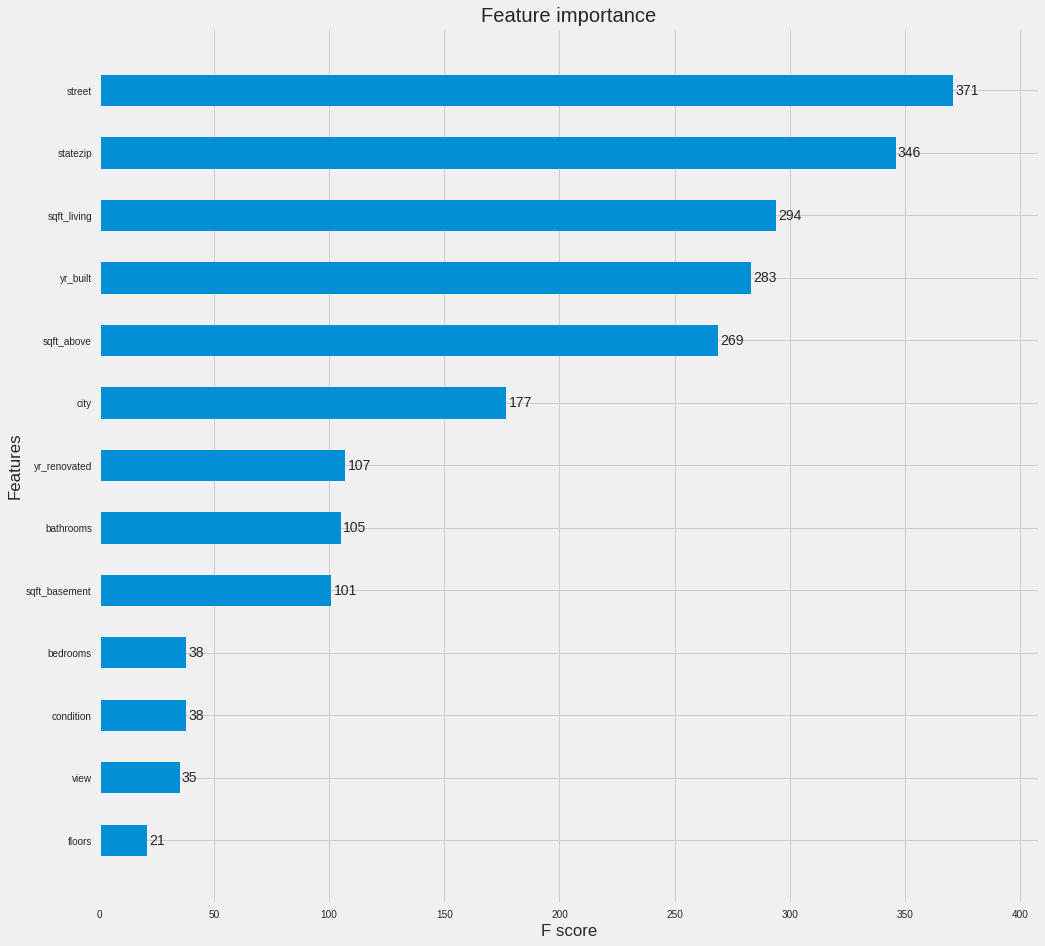

In [31]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

In [32]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,bedrooms,175,38.0
1,bathrooms,375,105.0
2,sqft_living,981,294.0
3,floors,81,21.0
4,waterfront,33,NaN
5,view,177,35.0
6,condition,160,38.0
7,sqft_above,943,269.0
8,sqft_basement,578,101.0
9,yr_built,843,283.0


<a class="anchor" id="4.3"></a>
### 4.3 Logistic Regression

In [33]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
# Standardization for regression model
train_fe = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(train_fe),
    columns=train_fe.columns,
    index=train_fe.index
)

In [34]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_fe, target_fe)
coeff_logreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_logreg.columns = ['feature']
coeff_logreg["score_logreg"] = pd.Series(logreg.coef_[0])
coeff_logreg.sort_values(by='score_logreg', ascending=False)

,feature,score_logreg
4,view,-0.010319
5,condition,-0.094632
8,yr_built,-0.311598
3,waterfront,-0.452528
6,sqft_above,-0.492565
2,floors,-0.549755
7,sqft_basement,-0.585525
13,country,-0.770921
1,sqft_living,-0.863389
10,street,-0.937493


In [35]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
# the level of importance of features is not associated with the sign
coeff_logreg["score_logreg"] = coeff_logreg["score_logreg"].abs()
feature_score = pd.merge(feature_score, coeff_logreg, on='feature')

<a class="anchor" id="4.4"></a>
### 4.4 Linear Regression

In [36]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
# Linear Regression

linreg = LinearRegression()
linreg.fit(train_fe, target_fe)
coeff_linreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
2,floors,383979.879252
7,sqft_basement,358736.341590
1,sqft_living,172327.946666
12,statezip,161437.496980
8,yr_built,122017.828318
5,condition,95337.374310
3,waterfront,74577.710640
4,view,58201.271352
6,sqft_above,33714.767014
11,city,22486.233400


In [37]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs()
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

,score_lgb,score_xgb,score_logreg,score_linreg
feature,,,,
bathrooms,375,105.0,1.515462,56518.652583
sqft_living,981,294.0,0.863389,172327.946666
floors,81,21.0,0.549755,383979.879252
waterfront,33,0.0,0.452528,74577.710640
view,177,35.0,0.010319,58201.271352
condition,160,38.0,0.094632,95337.374310
sqft_above,943,269.0,0.492565,33714.767014
sqft_basement,578,101.0,0.585525,358736.341590
yr_built,843,283.0,0.311598,122017.828318


<a class="anchor" id="5"></a>
## 5. Comparison of the all feature importance diagrams 

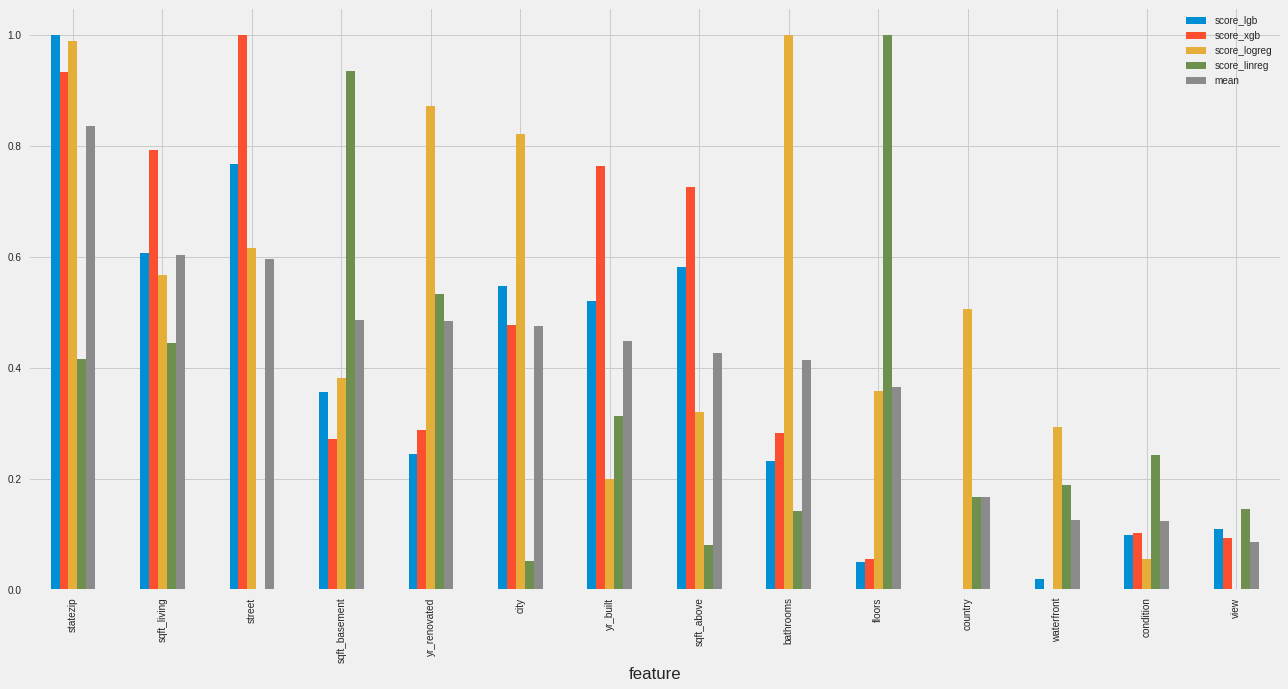

In [38]:
# Thanks to: https://www.kaggle.com/vbmokin/feature-importance-xgb-lgbm-logreg-linreg
# Thanks to: https://www.kaggle.com/nanomathias/feature-engineering-importance-testing
# MinMax scale all importances
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

# Create mean column
feature_score['mean'] = feature_score.mean(axis=1)

# Plot the feature importances
feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 10))

In [39]:
feature_score.sort_values('mean', ascending=False)

,score_lgb,score_xgb,score_logreg,score_linreg,mean
feature,,,,,
statezip,1.000000,0.932615,0.989111,0.416598,0.834581
sqft_living,0.605930,0.792453,0.566770,0.445148,0.602575
street,0.767758,1.000000,0.616003,0.000000,0.595940
sqft_basement,0.357011,0.272237,0.382160,0.933823,0.486308
yr_renovated,0.244595,0.288410,0.872130,0.533562,0.484674
city,0.547251,0.477089,0.821696,0.052333,0.474592
yr_built,0.520692,0.762803,0.200166,0.313258,0.449230
sqft_above,0.582458,0.725067,0.320398,0.081769,0.427423
bathrooms,0.231624,0.283019,1.000000,0.141550,0.414048


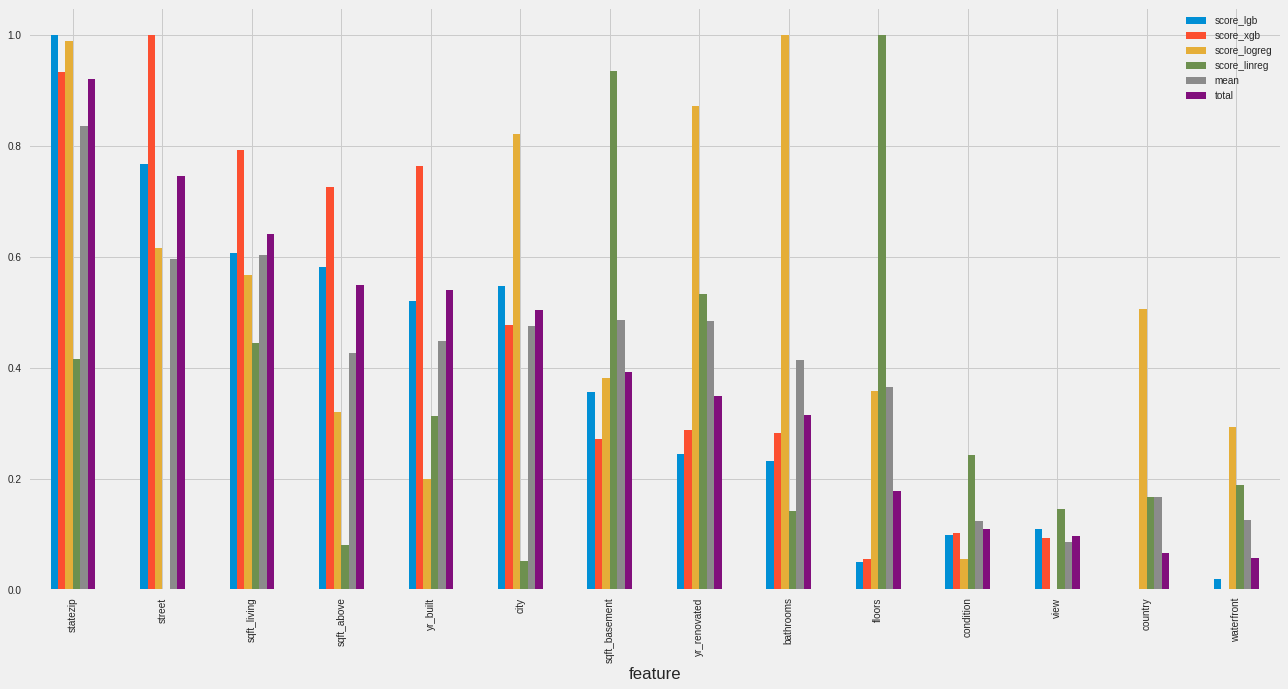

In [40]:
# Thanks to: Thanks to: https://www.kaggle.com/vbmokin/feature-importance-xgb-lgbm-logreg-linreg
# Create total column with different weights
feature_score['total'] = 0.5*feature_score['score_lgb'] + 0.3*feature_score['score_xgb'] \
                       + 0.1*feature_score['score_logreg'] + 0.1*feature_score['score_linreg']

# Plot the feature importances
feature_score.sort_values('total', ascending=False).plot(kind='bar', figsize=(20, 10))

In [41]:
feature_score.sort_values('total', ascending=False)

,score_lgb,score_xgb,score_logreg,score_linreg,mean,total
feature,,,,,,
statezip,1.000000,0.932615,0.989111,0.416598,0.834581,0.920355
street,0.767758,1.000000,0.616003,0.000000,0.595940,0.745479
sqft_living,0.605930,0.792453,0.566770,0.445148,0.602575,0.641892
sqft_above,0.582458,0.725067,0.320398,0.081769,0.427423,0.548966
yr_built,0.520692,0.762803,0.200166,0.313258,0.449230,0.540529
city,0.547251,0.477089,0.821696,0.052333,0.474592,0.504155
sqft_basement,0.357011,0.272237,0.382160,0.933823,0.486308,0.391775
yr_renovated,0.244595,0.288410,0.872130,0.533562,0.484674,0.349390
bathrooms,0.231624,0.283019,1.000000,0.141550,0.414048,0.314873


<a class="anchor" id="6"></a>
## 6. Dada for modeling

In [42]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
target_name = 'price'
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [43]:
# Synthesis test0 from train0
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)

In [44]:
# For boosting model
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)

In [45]:
#For models from Sklearn
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [46]:
train0.head(3)

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,1.159940,-0.474931,-0.213526,-0.816707,-0.058065,-0.25505,0.861578,-0.911472,1.215224,0.273110,-0.836333,-1.295291,-0.659430,-0.969958,0.0
1,-0.335072,0.666744,-0.397024,0.971755,-0.058065,-0.25505,-0.694281,-0.026586,-0.669818,1.052604,-0.836333,1.503512,-0.996031,-1.261652,0.0
2,-1.830083,-1.616606,-1.003980,-0.816707,-0.058065,-0.25505,-0.694281,-1.477219,0.782174,-1.590898,1.203588,1.501974,0.771122,0.828817,0.0


In [47]:
len(train0)

2976

In [48]:
# Synthesis valid as test for selection models
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [49]:
train.head(3)

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2456,-1.830083,-1.616606,-0.919288,-0.816707,-0.058065,-0.25505,0.861578,-0.563320,-0.669818,-2.133155,1.190342,-0.468267,0.771122,1.217741,0.0
2880,-0.335072,0.666744,-0.411140,2.760217,-0.058065,-0.25505,-0.694281,-0.041092,-0.669818,-2.133155,1.199512,0.477233,0.771122,0.439892,0.0
1485,-0.335072,0.666744,0.280507,0.971755,-0.058065,-0.25505,-0.694281,0.669718,-0.669818,1.052604,-0.836333,-0.669061,-0.827731,-1.067190,0.0


In [50]:
test.head(3)

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2783,-0.335072,-0.855489,-0.989865,0.971755,-0.058065,-0.25505,-0.694281,-0.911472,-0.185821,1.086495,1.204607,0.512622,0.771122,1.703896,0.0
2188,-1.830083,-1.616606,-1.258054,-0.816707,-0.058065,-0.25505,-0.694281,-0.911472,-0.669818,-0.472493,1.205626,-1.433000,0.518671,-0.143494,0.0
2440,-0.335072,-0.474931,0.012318,-0.816707,-0.058065,-0.25505,0.861578,0.394098,-0.669818,0.035873,-0.836333,0.349525,-1.921682,-1.553345,0.0


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 2456 to 2732
Data columns (total 15 columns):
bedrooms         2083 non-null float64
bathrooms        2083 non-null float64
sqft_living      2083 non-null float64
floors           2083 non-null float64
waterfront       2083 non-null float64
view             2083 non-null float64
condition        2083 non-null float64
sqft_above       2083 non-null float64
sqft_basement    2083 non-null float64
yr_built         2083 non-null float64
yr_renovated     2083 non-null float64
street           2083 non-null float64
city             2083 non-null float64
statezip         2083 non-null float64
country          2083 non-null float64
dtypes: float64(15)
memory usage: 260.4 KB


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893 entries, 2783 to 988
Data columns (total 15 columns):
bedrooms         893 non-null float64
bathrooms        893 non-null float64
sqft_living      893 non-null float64
floors           893 non-null float64
waterfront       893 non-null float64
view             893 non-null float64
condition        893 non-null float64
sqft_above       893 non-null float64
sqft_basement    893 non-null float64
yr_built         893 non-null float64
yr_renovated     893 non-null float64
street           893 non-null float64
city             893 non-null float64
statezip         893 non-null float64
country          893 non-null float64
dtypes: float64(15)
memory usage: 111.6 KB


<a class="anchor" id="7"></a>
## 7. Preparing to modeling

In [53]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [54]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [55]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [56]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
def acc_model(num,model,train,test):
    # Calculation of accuracy of model from Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

<a class="anchor" id="8"></a>
## 8. Tuning models
##### [Back to Table of Contents](#0.1)

<a class="anchor" id="8.1"></a>
### 8.1 Random Forest

In [57]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
# Random Forest

#random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
acc_model(1,random_forest,train,test)

target =  [395000 670000 619500 400000 700000]
ytrain =  [429600.  654900.  576100.  410536.8 644000. ]
acc(r2_score) for train = 94.01
acc(relative error) for train = 6.69
acc(rmse) for train = 4707675.9
target_test = [386000 230000 530000 569000 710000]
ytest = [388300.4 217296.9 519895.  502520.  606140. ]
acc(r2_score) for test = 65.32
acc(relative error) for test = 16.7
acc(rmse) for test = 11014819.68


<a class="anchor" id="8.2"></a>
### 8.2 XGB

In [58]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(2,xgb_reg,trainb,testb)

[01:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.724
Best parameters set: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 140, 'reg_lambda': 0.5}
target =  [395000 670000 619500 400000 700000]
ytrain =  [414169.3  674493.8  548002.44 408806.72 713910.06]
acc(r2_score) for train = 92.11
acc(relative error) for train = 8.27
acc(rmse) for train = 5401611.42
target_test = [386000 230000 530000 569000 710000]
ytest = [485948.34 222938.27 527516.7  607059.56 591285.2 ]
acc(r2_score) for test = 74.62
acc(relative error) for test = 14.14
acc(rmse) for test = 9422841.15


<a class="anchor" id="8.3"></a>
### 8.3 LGBM

In [59]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [60]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[500]	valid_0's rmse: 96541.2
[1000]	valid_0's rmse: 94645.3
[1500]	valid_0's rmse: 94852.9
[2000]	valid_0's rmse: 95258.8
[2500]	valid_0's rmse: 95606.3
[3000]	valid_0's rmse: 95940.7
[3500]	valid_0's rmse: 96293.7
[4000]	valid_0's rmse: 96575.5
[4500]	valid_0's rmse: 96828.1
[5000]	valid_0's rmse: 96989.7
[5500]	valid_0's rmse: 97102
[6000]	valid_0's rmse: 97229.5
[6500]	valid_0's rmse: 97350.8
[7000]	valid_0's rmse: 97447.8
[7500]	valid_0's rmse: 97523.9
[8000]	valid_0's rmse: 97585.2
[8500]	valid_0's rmse: 97629.4
[9000]	valid_0's rmse: 97658.8
Early stopping, best iteration is:
[1212]	valid_0's rmse: 94494.9


In [61]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration)

target =  [395000 670000 619500 400000 700000]
ytrain =  [437698.2750742  679677.31609685 589692.21651901 471346.95729705
 713349.33620386]
acc(r2_score) for train = 91.3
acc(relative error) for train = 8.08
acc(rmse) for train = 5673531.63
target_test = [386000 230000 530000 569000 710000]
ytest = [523096.73610176 249253.36260031 556305.02977394 588583.33479625
 612523.64349738]
acc(r2_score) for test = 75.32
acc(relative error) for test = 14.0
acc(rmse) for test = 9292918.06


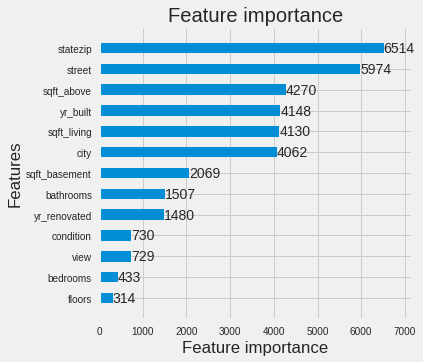

In [62]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

<a class="anchor" id="9"></a>
### 9 Models comparison

In [63]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGB', 'LGBM'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [64]:
pd.options.display.float_format = '{:,.2f}'.format

In [65]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
2,LGBM,91.30,75.32,8.08,14.00,"5,673,531.63","9,292,918.06"
1,XGB,92.11,74.62,8.27,14.14,"5,401,611.42","9,422,841.15"
0,Random Forest,94.01,65.32,6.69,16.70,"4,707,675.90","11,014,819.68"


In [66]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
2,LGBM,91.30,75.32,8.08,14.00,"5,673,531.63","9,292,918.06"
1,XGB,92.11,74.62,8.27,14.14,"5,401,611.42","9,422,841.15"
0,Random Forest,94.01,65.32,6.69,16.70,"4,707,675.90","11,014,819.68"


In [67]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
2,LGBM,91.30,75.32,8.08,14.00,"5,673,531.63","9,292,918.06"
1,XGB,92.11,74.62,8.27,14.14,"5,401,611.42","9,422,841.15"
0,Random Forest,94.01,65.32,6.69,16.70,"4,707,675.90","11,014,819.68"


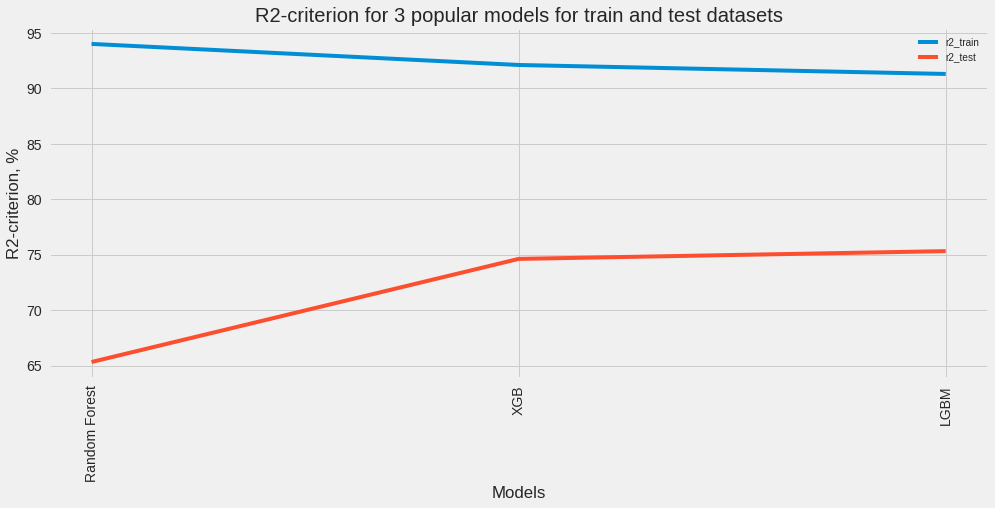

In [68]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
# Plot
plt.figure(figsize=[15,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 3 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

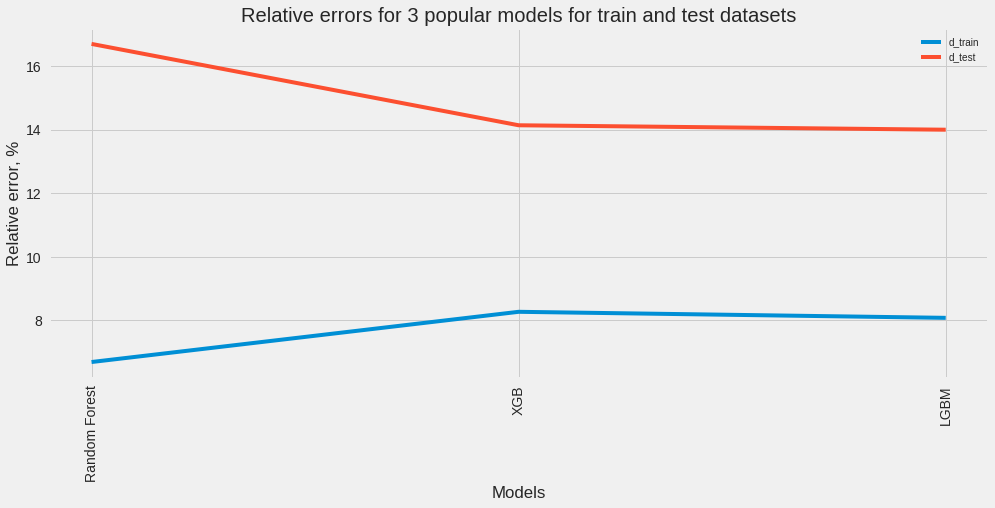

In [69]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
# Plot
plt.figure(figsize=[15,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 3 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

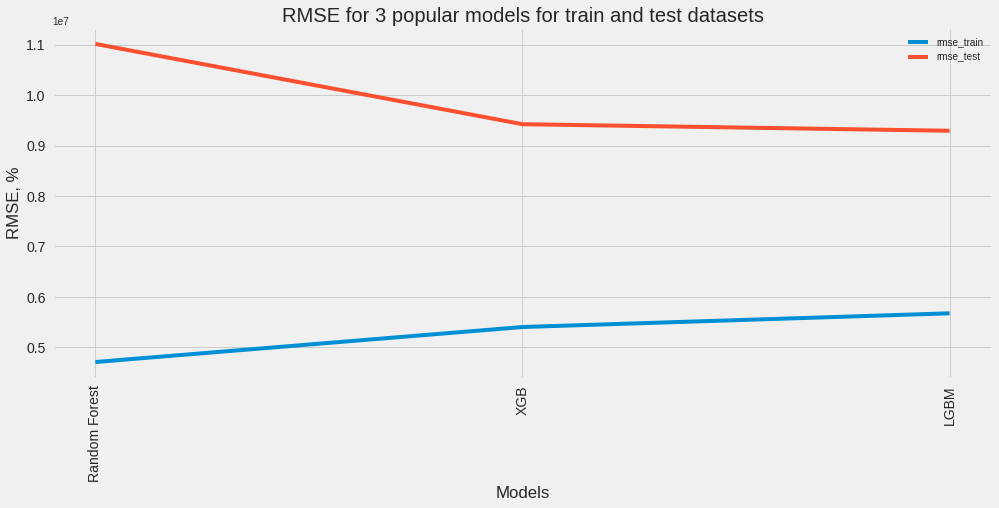

In [70]:
# Thanks to: https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models
# Plot
plt.figure(figsize=[15,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 3 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

<a class="anchor" id="10"></a>
### 10 Prediction

In [71]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 2639 to 3278
Data columns (total 15 columns):
bedrooms         744 non-null int64
bathrooms        744 non-null float64
sqft_living      744 non-null int64
floors           744 non-null int64
waterfront       744 non-null int64
view             744 non-null int64
condition        744 non-null int64
sqft_above       744 non-null int64
sqft_basement    744 non-null int64
yr_built         744 non-null int64
yr_renovated     744 non-null int64
street           744 non-null int64
city             744 non-null int64
statezip         744 non-null int64
country          744 non-null int64
dtypes: float64(1), int64(14)
memory usage: 93.0 KB


In [72]:
test0.head(3)

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2639,3,1.75,2240,2,0,0,5,2240,0,1976,0,1085,41,40,0
1824,2,2.50,2680,1,0,0,3,2680,0,2006,0,2064,31,32,0
2169,3,1.75,2210,1,0,0,3,1390,820,1958,2004,1691,3,4,0


In [73]:
#For models from Sklearn
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [74]:
# LGB Regression model for basic train
lgb_predict = modelL.predict(test0)
lgb_predict[:3]

array([482374.60724722, 727867.13305203, 607814.47676365])

In [75]:
# Thanks to: https://www.kaggle.com/dnzcihan/house-sales-prediction-and-eda
final_df = test_target0.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
final_df['predicted_prices'] = lgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(20)

,Real_price,predicted_prices,difference
0,550000,482374,67626
1,930000,727867,202133
2,625000,607814,17186
3,399950,413475,13525
4,530000,657266,127266
5,723000,651700,71300
6,250000,338338,88338
7,657500,719567,62067
8,320000,310798,9202
9,594950,671661,76711
